# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

# Manipulation des données

Dans cette partie, je modifie le dataset d'airbnb que j'ai récupéré pour avoir que les données qui me serviront dans le machine learning et que je trouve pertinente.

Pour cela je vais :
1. sélectionner les colonnes pertinentes
2. remplacer les colonnes cleaning_fee et instant_bookable par des 1 et des 0
3. supprimer les appartements qui n'ont pas de reviews (je considère qu'ils n'ont pas été loués)
4. récupérer le prix en $ (actuellement en logarithme)
5. Remplacer les choix contenu dans les colonnes city et cancellation_policy par plusieurs colonnes en 1 et 0
6. Transformer les dates en timestamp pour pouvoir les manipuler


PS : Je voudrais calculer des catégories de prix mais cela ne me semble pas possible avec les données réelles car pour New-York le prix moyen est de 396€ ce qui me semble beaucoup trop élevé pour le dataset que je possède. L'on peut voir un échantillon des prix pour cette ville dans le dernier print avant le `df.head()`.
Donc je fais un calcule avec les données que je possède dans la partie suivante

In [56]:
df = pd.read_csv('data/airbnb_data.csv')

df = df[['log_price', 'room_type', 'accommodates', 'cancellation_policy', 'cleaning_fee', 'city', 'first_review', 'instant_bookable', 'number_of_reviews', 'review_scores_rating', 'bedrooms']]
df['cleaning_fee'] = df['cleaning_fee'].astype(int)
df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 1 if x == 'f' else 0)
df = df.dropna(axis=0, subset=['first_review'])
df['price_by_night'] = np.exp(df['log_price'])
df = df.drop(labels='log_price', axis=1)
df['price_by_person'] = df['price_by_night'] / df['accommodates']

unique_cities = df['city'].unique()
print(unique_cities) # ['NYC' 'DC' 'SF' 'LA' 'Chicago' 'Boston']
city = df['city']
df = pd.get_dummies(df, columns=['city'], dtype=int)
df['city'] = city

unique_policies = df['cancellation_policy'].unique()
print(unique_policies) # ['strict' 'moderate' 'flexible' 'super_strict_30' 'super_strict_60']

unique_room_type = df['room_type'].unique()
print(unique_room_type) # ['Entire home/apt' 'Private room' 'Shared room']

print(df['cleaning_fee'].value_counts())

df['first_review'] = pd.to_datetime(df['first_review'])
df['first_review_timestamp'] = df['first_review'].apply(lambda x: x.timestamp())

df_ny = df[(df['city_NYC'] == 1)]
print(df_ny['price_by_night'])

missing_review = df['review_scores_rating'].isna().sum()
print(f"{missing_review=}")
df = df.dropna(subset=['review_scores_rating'])

print(df.columns)
df.head()

['NYC' 'DC' 'SF' 'LA' 'Chicago' 'Boston']
['strict' 'moderate' 'flexible' 'super_strict_30' 'super_strict_60']
['Entire home/apt' 'Private room' 'Shared room']
cleaning_fee
1    46063
0    12184
Name: count, dtype: int64
0        150.0
1        169.0
2        145.0
10       100.0
18       132.0
         ...  
74094     40.0
74096     50.0
74097    110.0
74100    100.0
74108    185.0
Name: price_by_night, Length: 25491, dtype: float64
missing_review=859
Index(['room_type', 'accommodates', 'cancellation_policy', 'cleaning_fee',
       'first_review', 'instant_bookable', 'number_of_reviews',
       'review_scores_rating', 'bedrooms', 'price_by_night', 'price_by_person',
       'city_Boston', 'city_Chicago', 'city_DC', 'city_LA', 'city_NYC',
       'city_SF', 'city', 'first_review_timestamp'],
      dtype='object')


,room_type,accommodates,cancellation_policy,cleaning_fee,first_review,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,price_by_night,price_by_person,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,city,first_review_timestamp
0,Entire home/apt,3,strict,1,2016-06-18,1,2,100.0,1.0,150.0,50.000000,0,0,0,0,1,0,NYC,1.466208e+09
1,Entire home/apt,7,strict,1,2017-08-05,0,6,93.0,3.0,169.0,24.142857,0,0,0,0,1,0,NYC,1.501891e+09
2,Entire home/apt,5,moderate,1,2017-04-30,0,10,92.0,1.0,145.0,29.000000,0,0,0,0,1,0,NYC,1.493510e+09
4,Entire home/apt,2,moderate,1,2015-05-12,0,4,40.0,0.0,115.0,57.500000,0,0,1,0,0,0,DC,1.431389e+09
5,Private room,2,strict,1,2017-08-27,0,3,100.0,1.0,85.0,42.500000,0,0,0,0,0,1,SF,1.503792e+09


# Numpy, Pandas & Matplop

## Calcule de la catégorie de prix pour chaque ville

Je vais appliquer le principe suivant (dans une boucle pour itérer sur chaque ville) :
1. Je récupère le prix et nombre de personnes acceptées pour chaque appartement
2. Je divise le prix par le nombre de personne (pour avoir le prix par personne)
3. Je calcule la moyenne de prix par personne

Une fois ma moyenne par ville calculée, j'itère pour chaque entrée de mon dataset (via `df.apply()`) :
1. Je calcule le prix par personne
2. je récupère la moyenne en fonction de la ville de l'appartement
3. J'applique des pourcentages au prix pour savoir dans quelle catégorie je le classe

Après cela, je calcule la moyenne de la note par catégorie, et je génère un graphique graphique de la répartition des appartements par catégorie avec la moyenne des notes.

/var/folders/b3/tn1zt4lx1j1_0hhxtfhfgwp80000gn/T/ipykernel_17973/158397371.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_city['price_per_person'] = df_city['price_by_night'] / df_city['accommodates']
/var/folders/b3/tn1zt4lx1j1_0hhxtfhfgwp80000gn/T/ipykernel_17973/158397371.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_city['price_per_person'] = df_city['price_by_night'] / df_city['accommodates']
/var/folders/b3/tn1zt4lx1j1_0hhxtfhfgwp80000gn/T/ipykernel_17973/158397371.py:6: SettingWithCo

{'NYC': 51.70403997177331, 'DC': 46.80620138905809, 'SF': 69.12293760441176, 'LA': 44.025696143257676, 'Chicago': 35.73900910628233, 'Boston': 53.51335476137339}


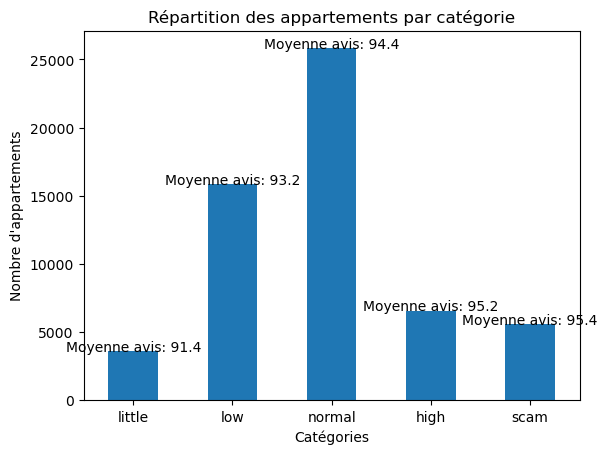

In [57]:
CITIES = unique_cities
averages = {}

for city in CITIES:
  df_city = df[df['city'] == city]
  df_city['price_per_person'] = df_city['price_by_night'] / df_city['accommodates']
  average = df_city['price_per_person'].mean()
  averages[city] = average

print(averages)

def categorize_price(row):
  price = row['price_by_night'] / row['accommodates']
  average = averages[row['city']]

  if price < average * 0.4:
    return 'little'
  elif price < average * 0.7:
    return 'low'
  elif price < average * 1.3:
    return 'normal'
  elif price < average * 1.7:
    return 'high'
  else:
    return 'scam'
  
df['category'] = df.apply(categorize_price, axis=1)
rating_category_average = df.groupby('category')['review_scores_rating'].mean()
category_order = ['little', 'low', 'normal', 'high', 'scam']
category_counts = df['category'].value_counts().reindex(category_order)

plt.figure()
ax = category_counts.plot(kind='bar')
plt.title('Répartition des appartements par catégorie')
plt.xlabel('Catégories')
plt.ylabel("Nombre d'appartements")
plt.xticks(rotation=0)

for i, (category, count) in enumerate(category_counts.items()):
    mean_rating = rating_category_average[category]
    ax.text(i, count + 0.5, f'Moyenne avis: {mean_rating:.1f}', ha='center', fontsize=10, color='black')

plt.show()

## Manipulation de l'année de premier commentaire

Je calcule la répartition appartements par année pour générer un graphique en bar. Je rajoute pour chaque année le prix moyen par nuit par personne et je le visualise via ue courbe verte sur le même graphique.

Date minimale :  2008-11-17 00:00:00
Date maximale :  2017-10-05 00:00:00
Moyenne de la date :  2016-01-11 17:54:40.825259686
year
2008    36.000000
2009    48.968380
2010    52.603781
2011    54.622992
2012    56.151820
2013    56.295113
2014    53.323807
2015    51.576790
2016    47.490819
2017    48.139435
Name: price_by_person, dtype: float64


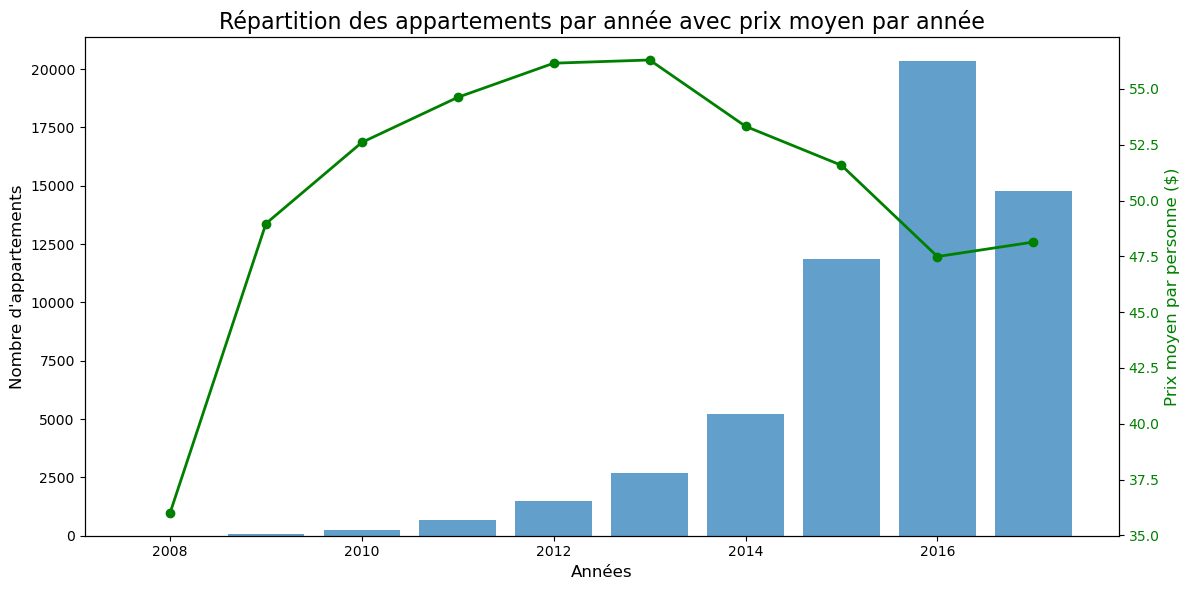

In [58]:
min_timestamp = df['first_review_timestamp'].min()
min_date = pd.to_datetime(min_timestamp, unit='s')

max_timestamp = df['first_review_timestamp'].max()
max_date = pd.to_datetime(max_timestamp, unit='s')

average_timestamp = df['first_review_timestamp'].mean()
average_date = pd.to_datetime(average_timestamp, unit='s')

print("Date minimale : ", min_date)
print("Date maximale : ", max_date)
print("Moyenne de la date : ", average_date)

df['year'] = df['first_review'].dt.year
year_counts = df['year'].value_counts().sort_index()
year_price_average = df.groupby('year')['price_by_person'].mean().sort_index()
print(year_price_average)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot
bars = ax1.bar(year_counts.index, year_counts.values, width=0.8, alpha=0.7)
ax1.set_xlabel('Années', fontsize=12)
ax1.set_ylabel("Nombre d'appartements", fontsize=12)
ax1.set_title('Répartition des appartements par année avec prix moyen par année', fontsize=16)
ax1.tick_params(axis='y')
plt.xticks(rotation=0)

# Line plot
ax2 = ax1.twinx()
line = ax2.plot(year_price_average.index, year_price_average.values, color='green', marker='o', linestyle='-', linewidth=2, markersize=6)
ax2.set_ylabel('Prix moyen par personne ($)', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Adjust layout and display
plt.tight_layout()
plt.show()

## Manipulation des colonnes frais de ménage et réservation immédiate

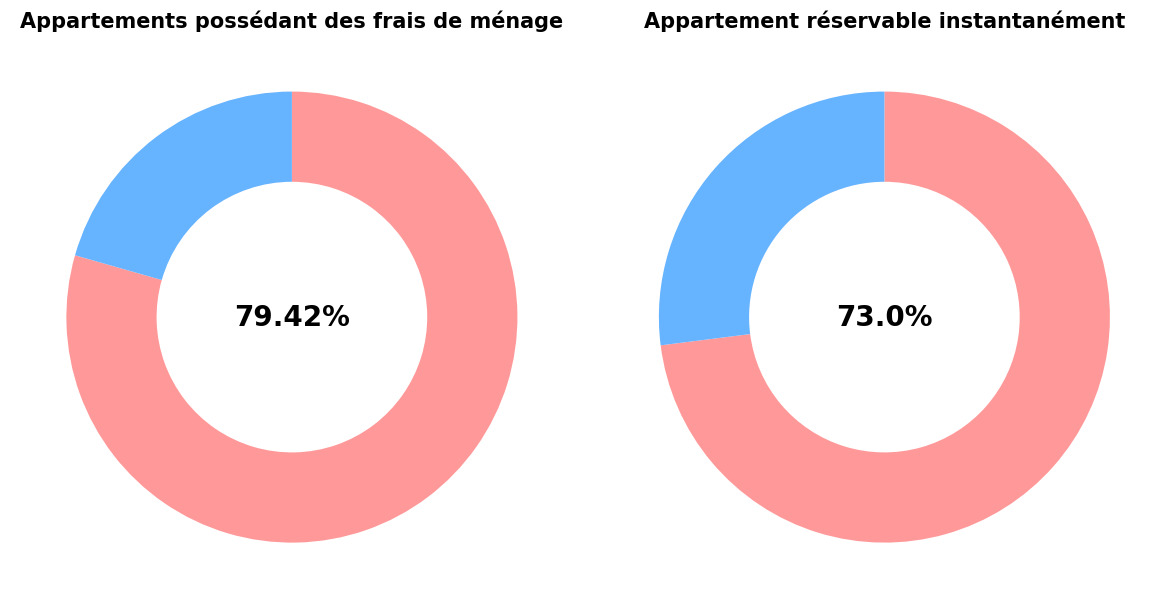

In [59]:
cleaning_fee_proportion = np.round(df['cleaning_fee'].mean() * 100, 2)
instant_bookable_proportion = np.round(df['instant_bookable'].mean() * 100)

cleaning = [cleaning_fee_proportion, 100 - cleaning_fee_proportion]
bookable = [instant_bookable_proportion, 100 - instant_bookable_proportion]

colors = ['#ff9999', '#66b3ff']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(cleaning, colors=colors, startangle=90, counterclock=False, wedgeprops=dict(width=0.4))
ax1.set_title("Appartements possédant des frais de ménage", fontsize=15, fontweight='bold')
ax1.text(0, 0, f"{cleaning_fee_proportion}%", ha='center', va='center', fontsize=20, fontweight='bold')

ax2.pie(bookable, colors=colors, startangle=90, counterclock=False, wedgeprops=dict(width=0.4))
ax2.set_title("Appartement réservable instantanément", fontsize=15, fontweight='bold')
ax2.text(0, 0, f"{instant_bookable_proportion}%", ha='center', va='center', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

## Nombres de personnes acceptées

Moyenne de personnes par appartement :  3.218268627587649
Médiane de personnes par appartement :  2.0
Variance de personnes par appartement :  4.597451812621364
Écart-type de personnes par appartement :  2.1441669274152524


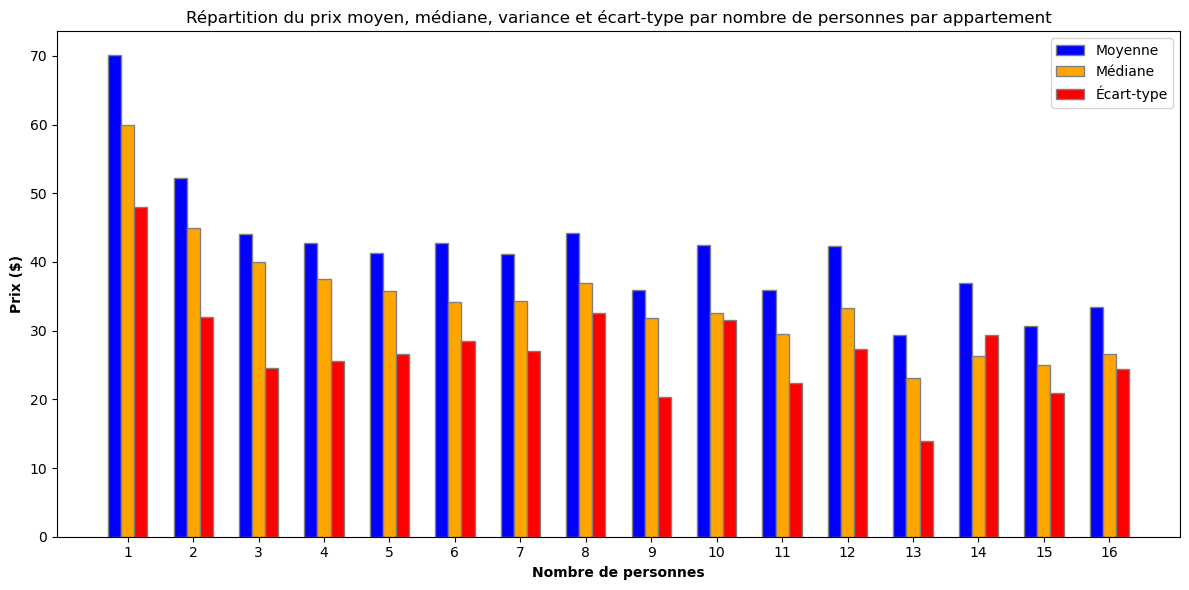

In [60]:
accommodates_average = df['accommodates'].mean()
accommodates_median = df['accommodates'].median()
accommodates_variance = df['accommodates'].var()
accommodates_deviation = df['accommodates'].std()

print("Moyenne de personnes par appartement : ", accommodates_average)
print("Médiane de personnes par appartement : ", accommodates_median)
print("Variance de personnes par appartement : ", accommodates_variance)
print("Écart-type de personnes par appartement : ", accommodates_deviation)

accommodates_price = df.groupby('accommodates')['price_by_person']
accommodates_price_average = accommodates_price.mean()
accommodates_price_median = accommodates_price.median()
accommodates_price_deviation = accommodates_price.std()

accommodates_df = pd.DataFrame({
    'average': accommodates_price_average,
    'median': accommodates_price_median,
    'deviation': accommodates_price_deviation
})

bar_width = 0.2

r1 = np.arange(len(accommodates_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(12, 6))

plt.bar(r1, accommodates_df['average'], color='blue', width=bar_width, edgecolor='grey', label='Moyenne')
plt.bar(r2, accommodates_df['median'], color='orange', width=bar_width, edgecolor='grey', label='Médiane')
plt.bar(r3, accommodates_df['deviation'], color='red', width=bar_width, edgecolor='grey', label='Écart-type')

plt.xlabel('Nombre de personnes', fontweight='bold')
plt.ylabel('Prix ($)', fontweight='bold')
plt.title('Répartition du prix moyen, médiane, variance et écart-type par nombre de personnes par appartement')
plt.xticks([r + bar_width for r in range(len(accommodates_df))], accommodates_df.index, rotation=0)

plt.legend()
plt.tight_layout()
plt.show()

## Heatmap de corrélation entre le prix et le nombre de personnes

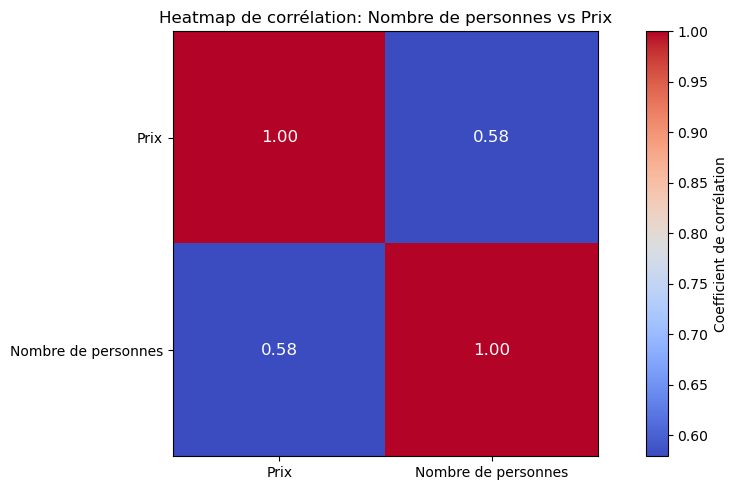

In [61]:
correlation = df[['price_by_night', 'accommodates']].corr()

plt.figure(figsize=(10, 5))
plt.imshow(correlation, cmap='coolwarm')
plt.colorbar(label='Coefficient de corrélation')

labels = ['Prix', 'Nombre de personnes']
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

# Afficher les valeurs dans les cellules
for i in range(len(correlation)):
    for j in range(len(correlation.columns)):
        plt.text(j, i, f'{correlation.iloc[i, j]:.2f}', ha='center', va='center', color='white', fontsize=12)


plt.title('Heatmap de corrélation: Nombre de personnes vs Prix')
plt.tight_layout()
plt.show()

# Machine Learning

## Régression linéaire sur le prix par personne en fonction du nombre de personnes

Coefficients :  [-2.65670704]
Intercept :  58.322064582533095
MSE:  1014.4107493225108
RMSE:  31.849815530431425
R² :  0.035504250860247


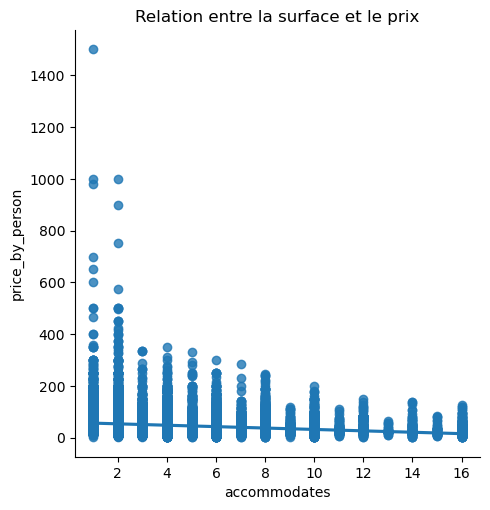

In [53]:
X = df[['accommodates']]
y = df['price_by_person']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Coefficients : ", model.coef_)
print("Intercept : ", model.intercept_)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ",np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² : ", r2_score(y_test, y_pred))

sns.lmplot(x='accommodates', y='price_by_person', data=df)
plt.title("Relation entre la surface et le prix")
plt.show()

Plusieurs solutions testées. Aucune satisfaisante. Je décide donc de ne pas aller plus loin.

## Régression linéaire sur le prix en fonction du nombre de personnes, de la ville, des frais de ménage et de la réservation instantané

Coefficients :  [3.71895827e+01 6.14967299e+00 2.06714958e+01 1.26384536e+12
 1.26384536e+12 1.26384536e+12 1.26384536e+12 1.26384536e+12
 1.26384536e+12]
Intercept :  -1263845361538.1726
MSE:  10525.90938362244
RMSE:  102.59585461227194
R² :  0.366277571316044


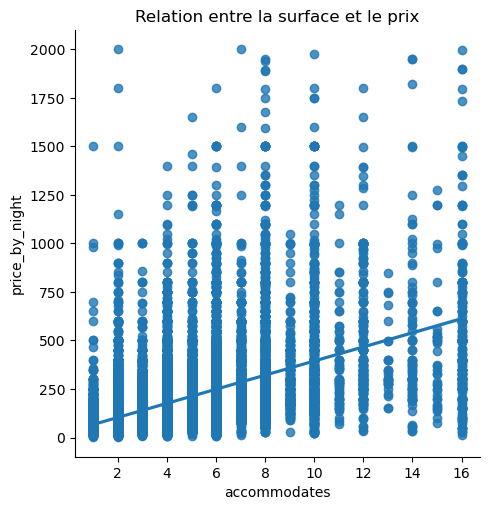

In [54]:
X = df[['accommodates', 'cleaning_fee', 'instant_bookable', 'city_NYC', 'city_DC', 'city_SF', 'city_LA', 'city_Chicago', 'city_Boston']]
y = df['price_by_night']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Coefficients : ", model.coef_)
print("Intercept : ", model.intercept_)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ",np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² : ", r2_score(y_test, y_pred))

sns.lmplot(x='accommodates', y='price_by_night', data=df)
plt.title("Relation entre la surface et le prix")
plt.show()

On supprime les extremes pour améliorer les résultats

Coefficients :  [37.36076139  4.54827451 10.12307543]
Intercept :  6.021725212423661
MSE:  3917.6805102927638
RMSE:  62.59137728387804
R² :  0.5982917064257693


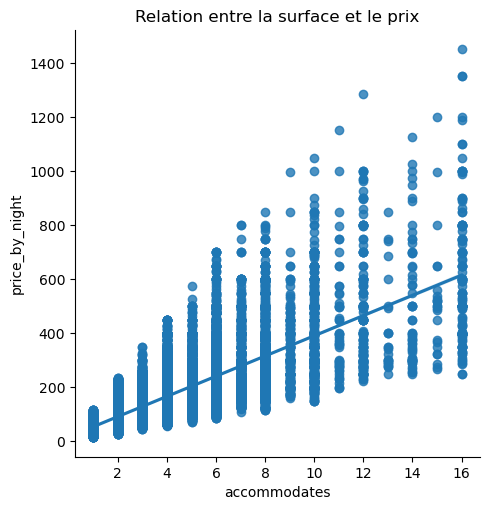

In [62]:
edited_df = df[~df['category'].isin(['little', 'scam'])]

X = edited_df[['accommodates', 'cleaning_fee', 'instant_bookable']]
y = edited_df['price_by_night']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Coefficients : ", model.coef_)
print("Intercept : ", model.intercept_)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ",np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² : ", r2_score(y_test, y_pred))

sns.lmplot(x='accommodates', y='price_by_night', data=edited_df)
plt.title("Relation entre la surface et le prix")
plt.show()

## Classification logistique s'il y a des frais de ménage en fonction du prix et de la ville

In [34]:
X = edited_df[['price_by_night', 'city_NYC', 'city_DC', 'city_SF', 'city_LA', 'city_Chicago', 'city_Boston']]
y = edited_df['cleaning_fee']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_model = LogisticRegression()
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

log_accuracy = accuracy_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
log_f1 = f1_score(y_test, y_pred)

print(f"Accuracy : {log_accuracy * 100:.2f}%")
print("Recall (rappel) :", log_recall)
print("F1-Score :", log_f1)

print("Coefficients du modèle : ", log_model.coef_)
print("Intercept du modèle : ", log_model.intercept_)
print(classification_report(y_test, y_pred))

Accuracy : 79.61%
Recall (rappel) : 1.0
F1-Score : 0.8864613991396876
Coefficients du modèle :  [[ 0.00712566 -0.07042405 -0.08289434 -0.00764811  0.44851488  0.05913572
   0.06288475]]
Intercept du modèle :  [0.412009]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2006
           1       0.80      1.00      0.89      7831

    accuracy                           0.80      9837
   macro avg       0.40      0.50      0.44      9837
weighted avg       0.63      0.80      0.71      9837



/opt/anaconda3/envs/esgi/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/esgi/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/esgi/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classification KNN s'il y a des frais de ménage en fonction du prix et de la ville

In [35]:
X = edited_df[['price_by_night', 'city_NYC', 'city_DC', 'city_SF', 'city_LA', 'city_Chicago', 'city_Boston']]
y = edited_df['cleaning_fee']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

knn_accuracy = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
knn_f1 = f1_score(y_test, y_pred)

print(f"Accuracy : {knn_accuracy * 100:.2f}%")
print("Recall (rappel) :", knn_recall)
print("F1-Score :", knn_f1)

print(classification_report(y_test, y_pred))

Accuracy : 74.92%
Recall (rappel) : 0.900523560209424
F1-Score : 0.8511254601412106
              precision    recall  f1-score   support

           0       0.29      0.16      0.20      2006
           1       0.81      0.90      0.85      7831

    accuracy                           0.75      9837
   macro avg       0.55      0.53      0.53      9837
weighted avg       0.70      0.75      0.72      9837



## Comparaison des deux classification précédentes

In [36]:
def compare(log, knn):
  if log > knn:
    print(f"Régression logistique plus précise de {(log - knn) * 100:.2f}%")
  else:
    print(f"Classification KNN plus précise de {(knn - log) * 100:.2f}%")

compare(log_accuracy, knn_accuracy)

Régression logistique plus précise de 4.69%
